In [7]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import scipy as sp
import statsmodels.formula.api as smf
from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt  
import seaborn as sns

In [2]:
df = pd.read_csv('./Project/data/marketing_AB.csv')
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [ ]:
# renaming the columns with '_' instead of spaces
df = df.rename(columns={
    'test group': 'test_group',
    'total ads': 'total_ads',
    'most ads day': 'most_ads_day',
    'most ads hour': 'most_ads_hour'
})

In [3]:
# ensuring correct data types
df['converted'] = df['converted'].astype(bool)
df['test_group'] = df['test_group'].astype('category')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   Unnamed: 0     588101 non-null  int64   
 1   user id        588101 non-null  int64   
 2   test group     588101 non-null  category
 3   converted      588101 non-null  bool    
 4   total ads      588101 non-null  int64   
 5   most ads day   588101 non-null  object  
 6   most ads hour  588101 non-null  int64   
dtypes: bool(1), category(1), int64(4), object(1)
memory usage: 23.6+ MB


## Preliminary analysis
Frquentist approach to see how each features influence the conversion rate 

### Effect of treatment (i.e. showing `ad`)
Note 'control' group is the group which is shown `psa`

In [155]:
# Aggregate conversion rate by test group
group_summary = df.groupby('test_group')['converted'].agg(['mean', 'count'])
print(group_summary)
print(f"The ratio of people coverted in the treatment group is {group_summary.loc['ad']['mean']: .4f}")
print(f"Compared to psa group which is {group_summary.loc['psa']['mean']:.4f}")
print("This shows there is higher chance of conversion when ad showed")
print(f"The lift ((P(ad|treatment) - P(psa|control)) / P(psa|control)) is:\
      {(group_summary.loc['ad']['mean'] - group_summary.loc['psa']['mean']) / group_summary.loc['psa']['mean'] * 100 : 0.2f} %")



                mean   count
test_group                  
ad          0.025547  564577
psa         0.017854   23524
The ratio of people coverted in the treatment group is  0.0255
Compared to psa group which is 0.0179
This shows there is higher chance of conversion when ad showed
The lift ((P(ad|treatment) - P(psa|control)) / P(psa|control)) is:       43.09 %


/var/folders/rn/n58cg6xx22lf00fqznzx3_vh0000gn/T/ipykernel_64185/3081701928.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_summary = df.groupby('test_group')['converted'].agg(['mean', 'count'])


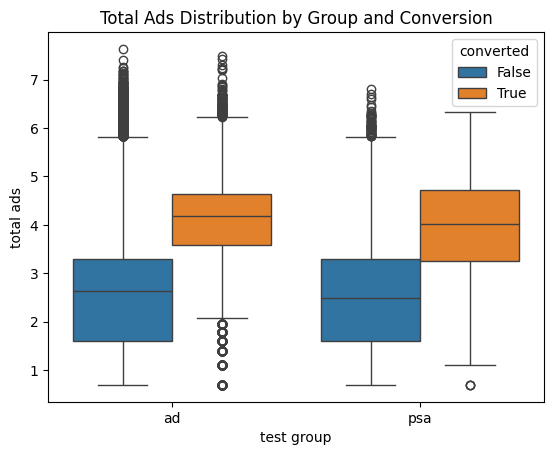

In [10]:
# Taking log(1+y) to see the differences more clearly
sns.boxplot(x='test group', y=np.log1p(df['total_ads']), hue='converted', data=df)
plt.title('Total Ads Distribution by Group and Conversion')
plt.show()

### Effect of 'Most watch day'

/var/folders/rn/n58cg6xx22lf00fqznzx3_vh0000gn/T/ipykernel_64185/1187623610.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  day_conv = df.groupby(['most ads day', 'test group'])['converted'].mean().unstack()


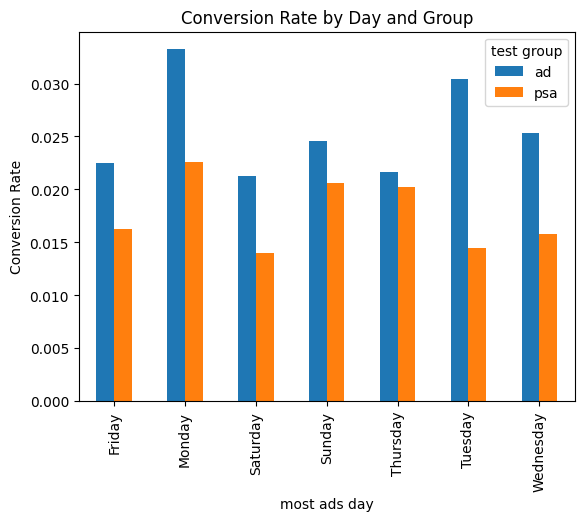

In [13]:
day_conv = df.groupby(['most_ads_day', 'test_group'])['converted'].mean().unstack()
day_conv.plot(kind='bar')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Day and Group')
plt.show()


In [174]:
day_summary = df.groupby(['most_ads_day', 'test_group'])['converted'].agg(['mean', 'count'])
day_summary_unstacked = day_summary.unstack('test_group')
day_summary_unstacked['lift']=(day_summary_unstacked['mean', 'ad'] - day_summary_unstacked['mean', 'psa'] ) / day_summary_unstacked['mean', 'psa'] 
day_summary_unstacked


/var/folders/rn/n58cg6xx22lf00fqznzx3_vh0000gn/T/ipykernel_64185/4048238062.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  day_summary = df.groupby(['most_ads_day', 'test_group'])['converted'].agg(['mean', 'count'])


mean            count            lift
test_group          ad       psa     ad   psa          
most_ads_day                                           
Friday        0.022465  0.016303  88805  3803  0.377971
Monday        0.033241  0.022559  83571  3502  0.473553
Saturday      0.021307  0.013996  78802  2858  0.522354
Sunday        0.024620  0.020595  82332  3059  0.195430
Thursday      0.021637  0.020230  79077  3905  0.069532
Tuesday       0.030440  0.014448  74572  2907  1.106909
Wednesday     0.025356  0.015759  77418  3490  0.608945

Some qualitative remarks:
1. Shows that some days (Monday) the conversion rate is higher compared to other for both groups.
2. Shows treatment as much higher on higher lift for some days (Tuesday, Saturday) compared to others

### Effect of 'most ads hour'

1. Similar analysis for the hours as well. But let me simplifyy by grouping into 4 divisions in a day as follows

In [ ]:
# Define sections of the day
def get_section(hour):
    if 2 <= hour <= 8:
        return '2-8'
    elif 9 <= hour <= 14:
        return '9-14'
    elif 15 <= hour <= 20:
        return '15-20'
    else:
        # Covers 21-23, 0-1 hours
        return '21-1'

df['section'] = df['most_ads_hour'].apply(get_section)

/var/folders/rn/n58cg6xx22lf00fqznzx3_vh0000gn/T/ipykernel_64185/3358062032.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  section_conv = df.groupby(['section', 'test_group'])['converted'].mean().unstack()


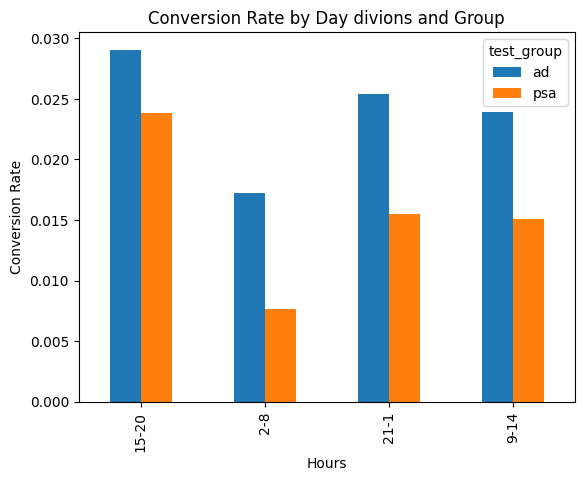

In [159]:
section_conv = df.groupby(['section', 'test_group'])['converted'].mean().unstack()
section_conv.plot(kind='bar')
plt.ylabel('Conversion Rate')
plt.xlabel('Hours')
plt.title('Conversion Rate by Day divions and Group')
plt.show()

In [175]:
hour_summary = df.groupby(['most_ads_hour', 'test_group'])['converted'].agg(['mean', 'count'])
hour_summary_unstacked = hour_summary.unstack('test_group')
hour_summary_unstacked['lift']=(hour_summary_unstacked['mean', 'ad'] - hour_summary_unstacked['mean', 'psa'] ) / hour_summary_unstacked['mean', 'psa'] 
hour_summary_unstacked

/var/folders/rn/n58cg6xx22lf00fqznzx3_vh0000gn/T/ipykernel_64185/1677575962.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hour_summary = df.groupby(['most_ads_hour', 'test_group'])['converted'].agg(['mean', 'count'])


mean            count            lift
test_group           ad       psa     ad   psa          
most_ads_hour                                           
0              0.019213  0.000000   5309   227       inf
1              0.013434  0.000000   4615   187       inf
2              0.007570  0.000000   5152   181       inf
3              0.010425  0.011236   2590    89 -0.072201
4              0.015850  0.000000    694    28       inf
5              0.021563  0.000000    742    23       inf
6              0.023174  0.000000   1985    83       inf
7              0.018482  0.008439   6168   237  1.190175
8              0.019861  0.010622  16968   659  0.869763
9              0.019529  0.010815  29802  1202  0.805671
10             0.021840  0.013468  37454  1485  0.621629
11             0.022469  0.014556  44149  2061  0.543645
12             0.024139  0.016990  45238  2060  0.420752
13             0.025063  0.016590  45485  2170  0.510754
14             0.028575  0.016051  43779  1869  0.780244
15             0.029845  0.025164  42855  1828  0.186007
16             0.030893  0.028055  35963  1604  0.101159
17             0.028537  0.020246  33605  1383  0.409545
18             0.027470  0.025177  31052  1271  0.091076
19             0.026809  0.024514  29169  1183  0.093634
20             0.030274  0.017642  27846  1077  0.716038
21             0.029175  0.022202  28895  1081  0.314073
22             0.026455  0.016358  25515   917  0.617284
23             0.022970  0.012924  19547   619  0.777325

In [176]:
section_summary = df.groupby(['section', 'test_group'])['converted'].agg(['mean', 'count'])
section_summary_unstacked = section_summary.unstack('test_group')
section_summary_unstacked['lift']=(section_summary_unstacked['mean', 'ad'] - section_summary_unstacked['mean', 'psa'] ) / section_summary_unstacked['mean', 'psa'] 
section_summary_unstacked

/var/folders/rn/n58cg6xx22lf00fqznzx3_vh0000gn/T/ipykernel_64185/1025030850.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  section_summary = df.groupby(['section', 'test_group'])['converted'].agg(['mean', 'count'])


mean             count             lift
test_group        ad       psa      ad    psa          
section                                                
15-20       0.029064  0.023844  200490   8346  0.218927
2-8         0.017202  0.007692   34299   1300  1.236217
21-1        0.025405  0.015506   83881   3031  0.638355
9-14        0.023891  0.015119  245907  10847  0.580166

Some remarks:
1. It appears that some hours (late afternoon or night time) are more effective compared to other for both the groups.
2. However, the `lift` seems to be much higher for the off-hours such as morning hours 7-11). But this could be an artifact of very few users in both the groups.

### Simple logistic regression estimation

In [31]:
model = smf.logit('converted ~ C(test_group) + total_ads + C(most_ads_day) + C(most_ads_hour)', data=df)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.108125
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               588101
Model:                          Logit   Df Residuals:                   588069
Method:                           MLE   Df Model:                           31
Date:                Sun, 07 Sep 2025   Pseudo R-squ.:                 0.08198
Time:                        18:31:49   Log-Likelihood:                -63588.
converged:                       True   LL-Null:                       -69267.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -4.5602      0.106    -43.120      0.000

Conclusions
Test group matters: The "ad" group has higher conversion odds than "psa".

Day of highest ads significantly impacts conversion rates, with some days better than baseline, especially Monday and Tuesday.

Total ads seen positively influence the chance of conversion, though the effect per ad is small but statistically significant due to large sample size.

The model fits better than null but explains only a modest fraction of variance (pseudo R-squared ~ 0.078)

## Bayesian modeling

1. To better quantify uncertainty and hierarchical/group-specific effects (e.g., separate effects per group/day).

2. To model potential interactions (e.g., ad effect varying by day).

3. To include random effects or non-linear terms for better flexibility

4. Although effects are clear, Bayesian modeling can better quantify uncertainty, incorporate hierarchical structure (group/day effects), and model any interactions that would have on each other features.

5. It offers richer inference and posterior distributions for prediction and decision making under uncertainty.

### Modeling day and hour influence
1. For this initial model, I will focus on the influence of `most_ads_day` and `section` while accounting for the `total_ads` as only a mean of the particular group.
2. This is not the complete model, but it is still rich enough to give some insights about the influence of features other than `total_ads`
3. Main reason for this simplifications is that this model is much faster since it effectively reduces to 56 rows = (2 groups * 7 days * 4 sections), while the full model contains a quarter of a million rows!

In [177]:
# aggregating by group, day, and section
agg = df.groupby(['test_group', 'most_ads_day', 'section']).agg(
    n=('user id', 'count'),
    k=('converted', 'sum'),
    mean_total_ads=('total_ads', 'mean')
).reset_index()
agg

/var/folders/rn/n58cg6xx22lf00fqznzx3_vh0000gn/T/ipykernel_64185/2439159020.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby(['test_group', 'most_ads_day', 'section']).agg(


,test_group,most_ads_day,section,n,k,mean_total_ads
0,ad,Friday,15-20,31097,783,26.571180
1,ad,Friday,2-8,5293,78,31.276592
2,ad,Friday,21-1,15116,335,26.916248
3,ad,Friday,9-14,37299,799,26.028821
4,ad,Monday,15-20,31435,1101,26.355273
5,ad,Monday,2-8,4639,119,26.127829
6,ad,Monday,21-1,12079,348,20.421392
7,ad,Monday,9-14,35418,1210,26.130583
8,ad,Saturday,15-20,29348,683,23.958225
9,ad,Saturday,2-8,4558,93,34.513164


In [179]:

# Factorize categorical variables to create indices for PyMC
agg['group_idx'], unique_groups = pd.factorize(agg['test_group'])
agg['day_idx'], unique_days = pd.factorize(agg['most_ads_day'])
agg['section_idx'], unique_sections = pd.factorize(agg['section'])
agg.head()

,test_group,most_ads_day,section,n,k,mean_total_ads,group_idx,day_idx,section_idx
0,ad,Friday,15-20,31097,783,26.571180,0,0,0
1,ad,Friday,2-8,5293,78,31.276592,0,0,1
2,ad,Friday,21-1,15116,335,26.916248,0,0,2
3,ad,Friday,9-14,37299,799,26.028821,0,0,3
4,ad,Monday,15-20,31435,1101,26.355273,0,1,0


In [45]:
agg_data = agg.copy()

### Model discription
Aggregate data has basically 56 groups or cells defined by unique combination of `(group, day, section)`
* `i` index the cells in aggregated data
* `k_i` is the number of conversion for each cell
* `n_i` is total number of users in cell `i`
* `x_i` is the average of `total_ads` for cell `i`
Then model the conversion counts 
`k_i` ~ Binomial(n_i, p_i) ,

where `p_i` is defined as

$$ z_i = \alpha^{group[i]} + \beta^{day[i]} + \gamma^{section[i]} + \theta * x_i$$

$$p_i = sigmoid(z_i)$$


Here $\alpha^{group[i]}, \beta^{day[i]}, \gamma^{section[i]} + \theta $ are the regression coefficients that model the effects of group, day, and section respectively.

And $\theta$ model the effects of mean total ads



In [64]:
# COORDS definition based on unique group/day/section
COORDS = {
    "group": unique_groups,
    "day": unique_days,
    "section": unique_sections,
    "cell": np.arange(len(agg_data)),
}

with pm.Model(coords=COORDS) as model:
    # Hyperpriors for group/day/section effects
    sigma_group = pm.HalfNormal("sigma_group", 1)
    sigma_day = pm.HalfNormal("sigma_day", 1)
    sigma_section = pm.HalfNormal("sigma_section", 1)

    # Partial pooling of intercepts    
    mu_base = pm.Normal("mu_base", mu=0, sigma=50)
    sigma_base = pm.HalfNormal("sigma_base", sigma=10)
    delta = pm.Normal("delta", mu=mu_base, sigma=sigma_base)
    alpha = pm.Normal("alpha", mu=0, sigma=sigma_group, dims="group")
    beta = pm.Normal("beta", mu=0, sigma=sigma_day, dims="day")
    gamma = pm.Normal("gamma", mu=0, sigma=sigma_section, dims="section")

    # Regression coefficient for mean total_ads (continuous)
    theta = pm.Normal("theta", mu=0, sigma=1)

    # Data inputs aligned with cells
    group_idx = pm.Data("group_idx", agg_data["group_idx"], dims="cell")
    day_idx = pm.Data("day_idx", agg_data["day_idx"], dims="cell")
    section_idx = pm.Data("section_idx", agg_data["section_idx"], dims="cell")
    n = pm.Data("n", agg_data["n"], dims="cell")  # total users per cell
    k = pm.Data("k", agg_data["k"], dims="cell")  # conversions per cell
    mean_ads = pm.Data("mean_ads", agg_data["mean_total_ads"], dims="cell")

    # Linear model for logit of conversion probability
    logit_p = (
        delta
        + alpha[group_idx]
        + beta[day_idx]
        + gamma[section_idx]
        + theta * pm.math.log(1 + mean_ads)
    )

    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))

    # Binomial likelihood
    obs = pm.Binomial("obs", n=n, p=p, observed=k, dims="cell")
    
    idata_model_tmp = pm.sample(tune=1000, draws=2000, chains=5, return_inferencedata=True)


/usr/local/lib/python3.9/site-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 2 jobs)
NUTS: [sigma_group, sigma_day, sigma_section, mu_base, sigma_base, delta, alpha, beta, gamma, theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS 

Sampling 5 chains for 1_000 tune and 2_000 draw iterations (5_000 + 10_000 draws total) took 1293 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.


In [49]:
az.summary(idata_model_tmp)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_base,-0.650,50.431,-97.048,90.823,0.768,0.564,4294.0,4906.0,1.0
delta,-0.645,51.486,-96.674,96.363,0.783,0.571,4317.0,4865.0,1.0
alpha[ad],-7.268,0.617,-8.383,-6.089,0.013,0.009,2450.0,2320.0,1.0
alpha[psa],-7.621,0.618,-8.731,-6.441,0.013,0.009,2451.0,2291.0,1.0
beta[Friday],-0.214,0.097,-0.398,-0.026,0.002,0.002,2155.0,2111.0,1.0
...,...,...,...,...,...,...,...,...,...
p[51],0.018,0.001,0.016,0.020,0.000,0.000,9114.0,7465.0,1.0
p[52],0.020,0.001,0.018,0.022,0.000,0.000,9606.0,7481.0,1.0
p[53],0.009,0.001,0.008,0.011,0.000,0.000,7482.0,7779.0,1.0
p[54],0.018,0.001,0.016,0.020,0.000,0.000,9818.0,7387.0,1.0


In [50]:
idata_model_tmp

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

### Checking model posterior predictivity

In [ ]:
# Generate posterior predictive samples (if not already done)
with model:
    #posterior_pred = pm.sample_posterior_predictive(idata_model_tmp, var_names=["obs"])
    posterior_pred = pm.sample_posterior_predictive(idata_model_tmp, predictions=True).predictions

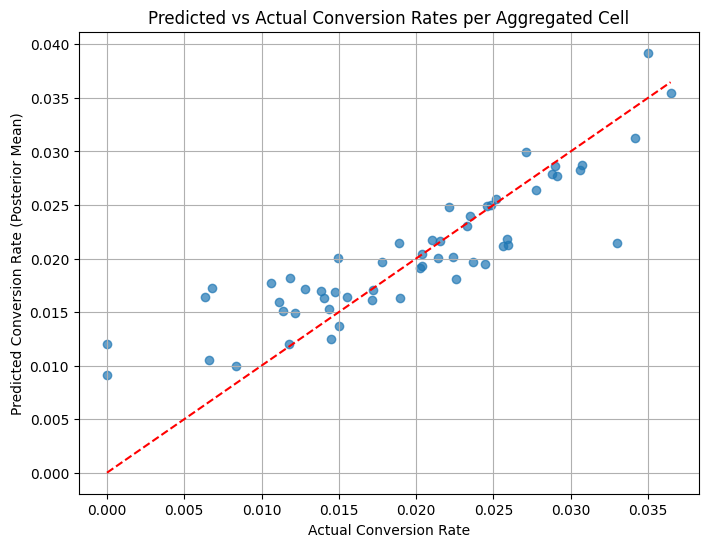

R-squared between predicted and actual conversion rates: 0.74391
Mean Squared Error: 0.0000179


In [181]:
# Extract mean predicted conversion rate per cell (posterior mean)
predicted_k_mean = posterior_pred.mean(dim=('chain', 'draw'))  # mean over draws
predicted_p_mean = predicted_k_mean.obs.values / agg_data["n"].values  # predicted conversion rate

# Actual conversion rate
actual_p = agg_data["k"].values / agg_data["n"].values

# Create a DataFrame for comparison
df_compare = pd.DataFrame({
    "predicted_conversion_rate": predicted_p_mean,
    "actual_conversion_rate": actual_p,
    "group": agg_data["test_group"],
    "day": agg_data["most_ads_day"],
    "section": agg_data["section"]
})

# Plot predicted vs actual conversion rates
plt.figure(figsize=(8, 6))
plt.scatter(df_compare["actual_conversion_rate"], df_compare["predicted_conversion_rate"], alpha=0.7)
plt.plot([0, df_compare["actual_conversion_rate"].max()], [0, df_compare["actual_conversion_rate"].max()], 'r--')
plt.xlabel("Actual Conversion Rate")
plt.ylabel("Predicted Conversion Rate (Posterior Mean)")
plt.title("Predicted vs Actual Conversion Rates per Aggregated Cell")
plt.grid(True)
plt.show()

# Optionally, summary statistics on predictive performance
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(df_compare["actual_conversion_rate"], df_compare["predicted_conversion_rate"])
mse = mean_squared_error(df_compare["actual_conversion_rate"], df_compare["predicted_conversion_rate"])

print(f"R-squared between predicted and actual conversion rates: {r2:.5f}")
print(f"Mean Squared Error: {mse:.7f}")


### Checking if the model confirms preliminary findings

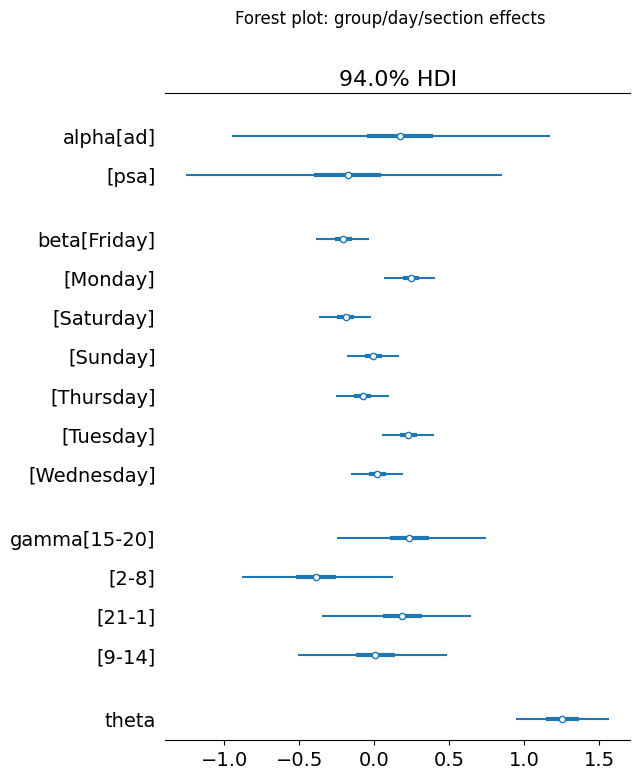

In [182]:
# 4. Forest plot for hierarchical group partial pooling visualization
az.plot_forest(idata_model_tmp, var_names=["alpha", "beta", "gamma", "theta"], combined=True)
plt.suptitle("Forest plot: group/day/section effects")
plt.show()

In [189]:
with model:
    ppc = pm.sample_posterior_predictive(idata_model_tmp, var_names=["obs"])


Sampling: [obs]


In [ ]:
# 1. pairwise parameter correlations to detect dependencies
az.plot_pair(idata_model_tmp, var_names=["alpha", "beta", "gamma", "theta"], kind="kde", marginals=True)
plt.suptitle("Posterior pairwise relationships")
plt.show()

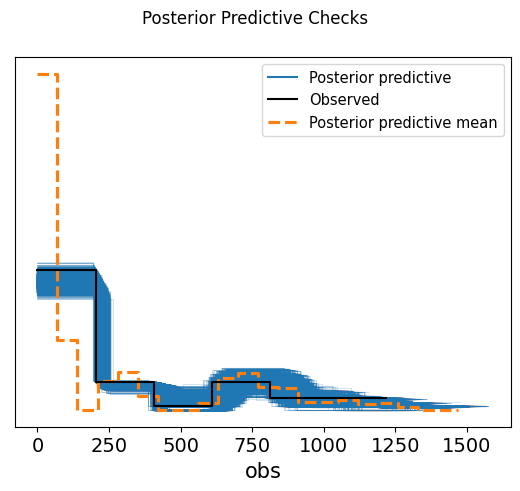

In [192]:


# 2. Posterior predictive checks (if available)
az.plot_ppc(ppc)
plt.suptitle("Posterior Predictive Checks")
plt.show()



### Which combination `(group, day, section)` has highest convertion rate?

Below we plot this for top 10 most effective combinations

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

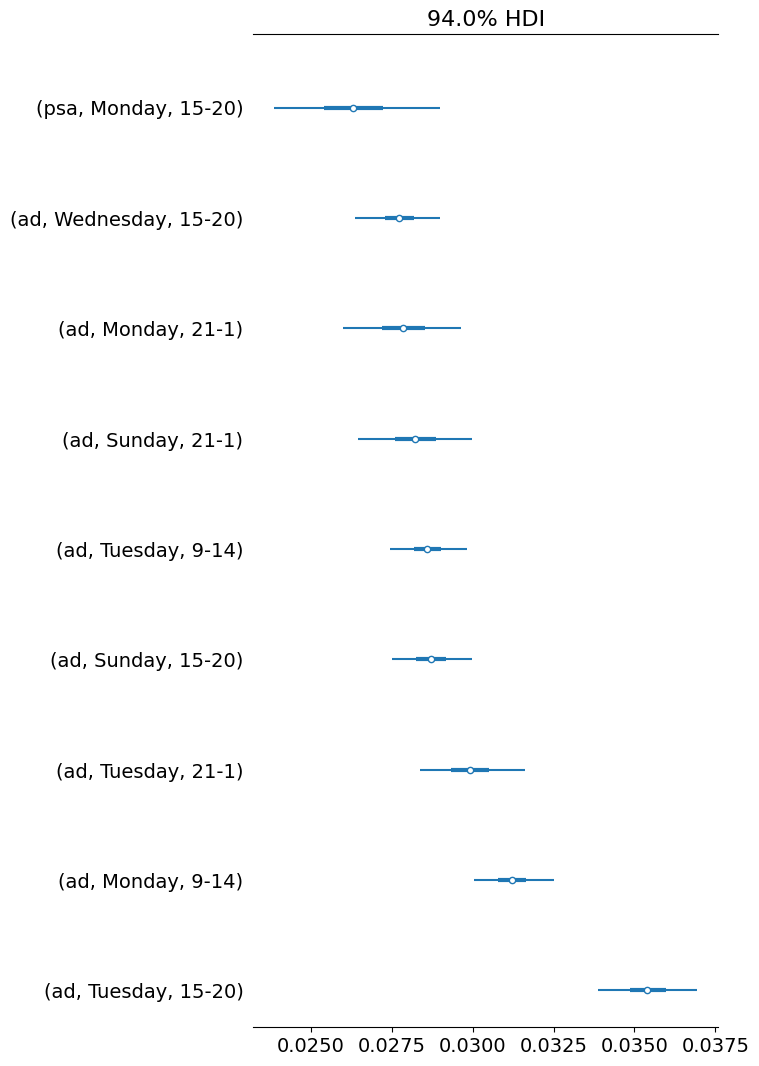

In [180]:
predicted_k_mean = posterior_pred.mean(dim=('chain', 'draw'))  # mean over draws
predicted_p_mean = predicted_k_mean.obs.values / agg_data["n"].values 
high_p_cells = (np.argsort(predicted_p_mean))[-10:-1] # getting top 10 maximum p values 
# posterior variables from InferenceData for plotting
posterior_vars = { f"({agg_data.loc[i,'test_group']}, {agg_data.loc[i,'most_ads_day']}, {agg_data.loc[i,'section']})" : idata_model_tmp.posterior["p"].sel(p_dim_0=i) for i in high_p_cells
}

# Plot forest with all chains combined (default)
az.plot_forest(posterior_vars, combined=True)

## Conclusions

1. Bayesian analysis confirms the influence of `total ads`, the day most watched and the hour most watched, which we found in the preliminary analysis
2. Here we obtained full probability distributions ( not just the point estimates) for each combination of (group, day, section), allowing us to see which are most significant.
3. Posterior checks showed a good match between model predictions and actual data, suggesting the model captured the main features of the data well
4. <p>If the marketing team wants the prime slots to choose to advertise then we found: <span style="background-color: yellow;"> Tuesday (15-23), Monday morning (9-14), or Sunday afternoon (15-20) are the best slots</span></p>
5. Many more precise probabilistic statements could be made based on the requirement. For now I will restrict to these above. 
6. In future, the model can be improved account for full ad exposure distribution than just mean value of the particular combination (group, day, section)

In [1]:
!pwd

/Users/nb33bp2ncbj/Library/Mobile Documents/com~apple~CloudDocs/Jobs/Statistics/python
